<a href="https://colab.research.google.com/github/asjadnazir/machine_learning/blob/main/bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [63]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [64]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == 'Yes').astype(int)
df = df[df["hour"] == 12]
df.drop(["hour"],axis=1)
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,12,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,12,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,12,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,12,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,12,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


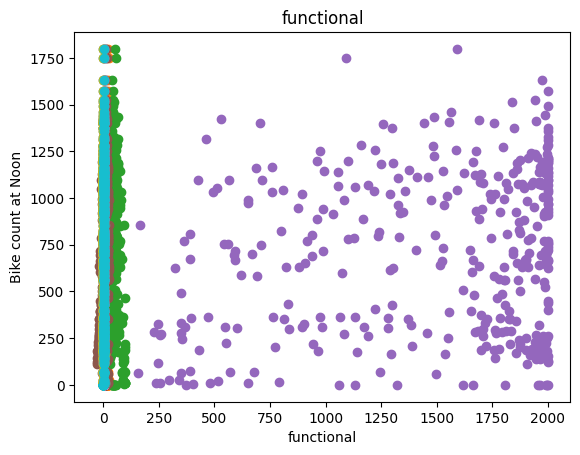

In [65]:
for label in df.columns[1:]:
  plt.scatter(df[label],df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike count at Noon")
  plt.xlabel(label)
  # plt.show()

In [66]:
df = df.drop(['wind','visibility','functional'],axis=1)
df.head()

,bike_count,hour,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,12,1.7,23,-17.2,1.11,0.0,0.0
36,479,12,4.3,41,-7.8,1.09,0.0,0.0
60,333,12,5.8,85,3.4,0.43,0.0,0.0
84,393,12,-0.3,38,-12.9,1.11,0.0,0.0
108,321,12,-2.3,25,-19.7,0.00,0.0,0.0


In [67]:
train,val,test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

In [68]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels)==1:
      X=dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X=dataframe[x_labels].values
  y=dataframe[y_label].values.reshape(-1,1)
  data=np.hstack((X,y))
  return data,X,y

Single Linear Regression

In [69]:
_,X_train_temp,y_train_temp = get_xy(train, "bike_count",x_labels=["temp"])
_,X_val_temp,y_val_temp = get_xy(val, "bike_count",x_labels=["temp"])
_,X_test_temp,y_test_temp = get_xy(test, "bike_count",x_labels=["temp"])

In [70]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp,y_train_temp)

LinearRegression()

In [71]:
temp_reg.score(X_test_temp,y_test_temp)

0.13676433238337804

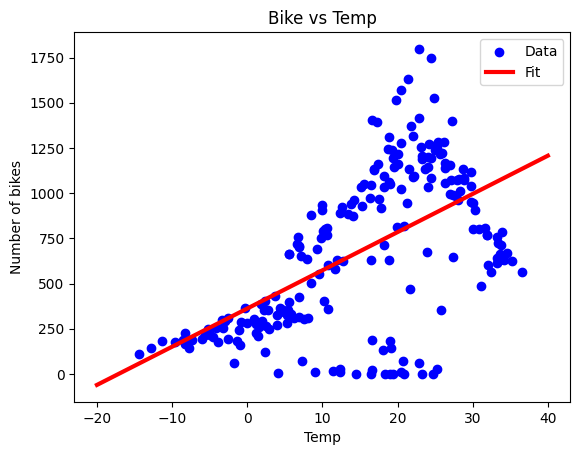

In [72]:
plt.scatter(X_train_temp, y_train_temp, label="Data",color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title('Bike vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

Multiple Liner Regression

In [73]:
train,val,test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])
_,X_train_all,y_train_all = get_xy(train, "bike_count",x_labels=df.columns[1:])
_,X_val_all,y_val_all = get_xy(val, "bike_count",x_labels=df.columns[1:])
_,X_test_all,y_test_all = get_xy(test, "bike_count",x_labels=df.columns[1:])

In [74]:
all_reg = LinearRegression()
all_reg.fit(X_train_all,y_train_all)

LinearRegression()

In [75]:
all_reg.score(X_test_all,y_test_all)

0.39498449295872096

In [76]:
y_pred_lr = all_reg.predict(X_test_all)

Regression with Neural Net

In [77]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [78]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [79]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [80]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [81]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1),y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp,y_val_temp)
)

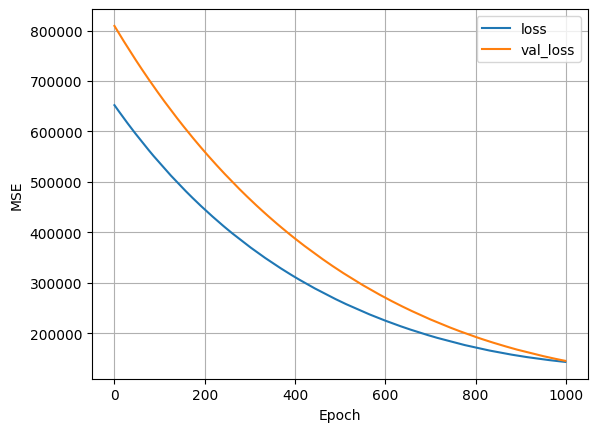

In [82]:
plot_loss(history)

4/4 [==============================] - 0s 5ms/step


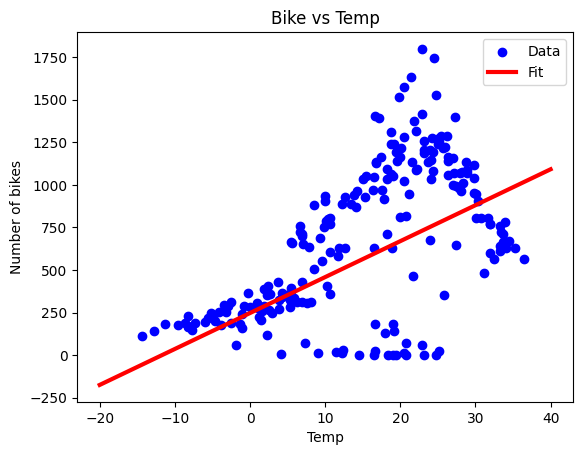

In [83]:
plt.scatter(X_train_temp, y_train_temp, label="Data",color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title('Bike vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

Neutal Net

In [84]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [85]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [86]:
history = nn_model.fit(
    X_train_temp,y_train_temp,
    validation_data=[X_val_temp,y_val_temp],
    verbose=0,epochs=100
)

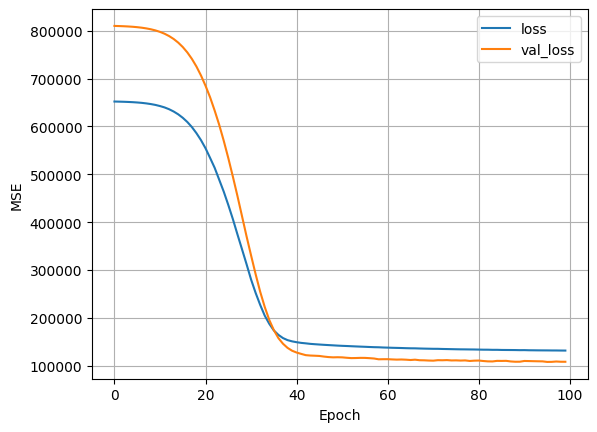

In [87]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


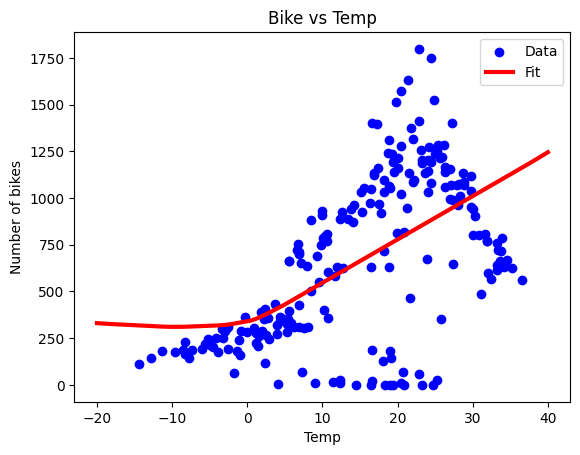

In [88]:
plt.scatter(X_train_temp, y_train_temp, label="Data",color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title('Bike vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

In [91]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(7,),axis=-1)
all_normalizer.adapt(X_train_all)

In [92]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32,activation= 'relu'),
    tf.keras.layers.Dense(32,activation= 'relu'),
    tf.keras.layers.Dense(1)
])

In [93]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [94]:
history = nn_model.fit(
    X_train_all,y_train_all,
    validation_data=[X_val_all,y_val_all],
    verbose=0,epochs=100
)

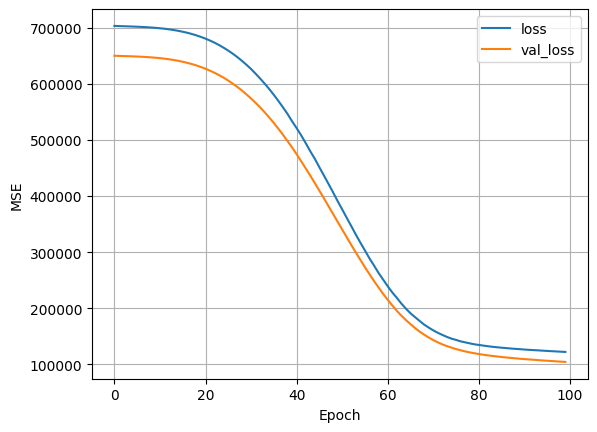

In [95]:
plot_loss(history)

In [96]:
#calclute mean for both
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 5ms/step


In [97]:
def MSE(y_pred,y_real):
  return (np.square(y_pred - y_real)).mean()

In [98]:
MSE(y_pred_lr,y_test_all)

99638.55086373708

In [99]:
MSE(y_pred_nn,y_test_all)

128982.46075015949

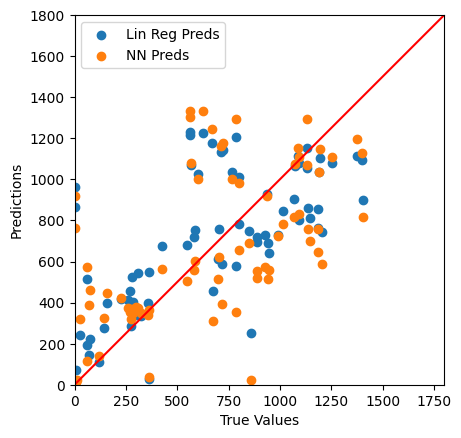

In [100]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all,y_pred_lr,label='Lin Reg Preds')
plt.scatter(y_test_all,y_pred_nn,label='NN Preds')
plt.xlabel("True Values")
plt.ylabel('Predictions')
lims = [0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims,lims,c="red")